In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import pickle

In [2]:
os.chdir('/project/ssverma_shared/projects/Endometriosis/Endo_Subtyping_Heterogeneity/Cluster_Training/')

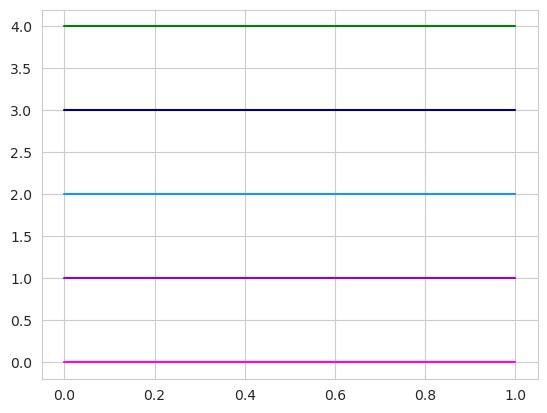

In [3]:
# Set up color palette to use for the five clusters
colors = ['fuchsia',
          'darkviolet',
          'dodgerblue',
          'mediumspringgreen',
          'g']

colors = ['fuchsia',
          'darkviolet',
          'dodgerblue',
          'navy',
          'g']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

for i in range(len(colors)):
    plt.plot([0, 1], [i, i])

plt.show()

In [4]:
model = pickle.load(open('Models/non_geno_PMBB_transfer_clusters.pickle', 'rb'))
data = pd.read_csv('Data/non_genotyped_PMBB_data_for_no_snps_clustering.csv', index_col='IID')

clusters = pd.Series(model.predict(data), index=data.index, name='Cluster')
clusters

IID
PMBB1001462384555    4
PMBB1002857391938    2
PMBB1003210639911    3
PMBB1003222496744    2
PMBB1003626451826    4
                    ..
PMBB9993259322112    4
PMBB9994756680249    4
PMBB9995182887713    3
PMBB9997370924922    3
PMBB9998857962671    2
Name: Cluster, Length: 4078, dtype: int64

In [5]:
data = pd.read_csv('../Feature_Extraction/Pheno/PMBB_2.3_pheno_covars.csv', index_col='PMBB_ID')
data = data[data['endometriosis'] == 1]
data = data[model.feature_names_in_]

clusters_geno = pd.Series(model.predict(data), index=data.index, name='Cluster')
clusters_geno

PMBB_ID
PMBB1019800003470    4
PMBB1026257511052    4
PMBB1039039281507    4
PMBB1052559903931    5
PMBB1058844982565    2
                    ..
PMBB9973887165525    4
PMBB9976071823730    3
PMBB9983585251407    2
PMBB9984110997233    5
PMBB9989729584956    2
Name: Cluster, Length: 1275, dtype: int64

236 1562 441 3637
48 371 441 3637
16 97 441 3637
35 289 441 3637
20 132 441 3637
259 2280 441 3637
8 52 441 3637
390 1983 441 3637
174 1161 441 3637
205 862 441 3637
73 623 441 3637
130 487 441 3637
124 231 441 3637
38 293 441 3637
186 1179 441 3637
121 380 441 3637
42 432 441 3637
185 1356 441 3637
250 1127 441 3637
163 832 441 3637
186 722 441 3637
40 200 441 3637
32 215 441 3637
126 290 441 3637
461 1337 686 3392
88 331 686 3392
28 85 686 3392
68 256 686 3392
31 121 686 3392
324 2215 686 3392
12 48 686 3392
389 1984 686 3392
177 1158 686 3392
258 809 686 3392
306 390 686 3392
138 479 686 3392
56 299 686 3392
62 269 686 3392
229 1136 686 3392
61 440 686 3392
125 349 686 3392
627 914 686 3392
479 898 686 3392
138 857 686 3392
190 718 686 3392
58 182 686 3392
58 189 686 3392
104 312 686 3392
453 1345 1151 2927
146 273 1151 2927
24 89 1151 2927
147 177 1151 2927
55 97 1151 2927
796 1743 1151 2927
19 41 1151 2927
999 1374 1151 2927
166 1169 1151 2927
237 830 1151 2927
262 434 1151 2927
1

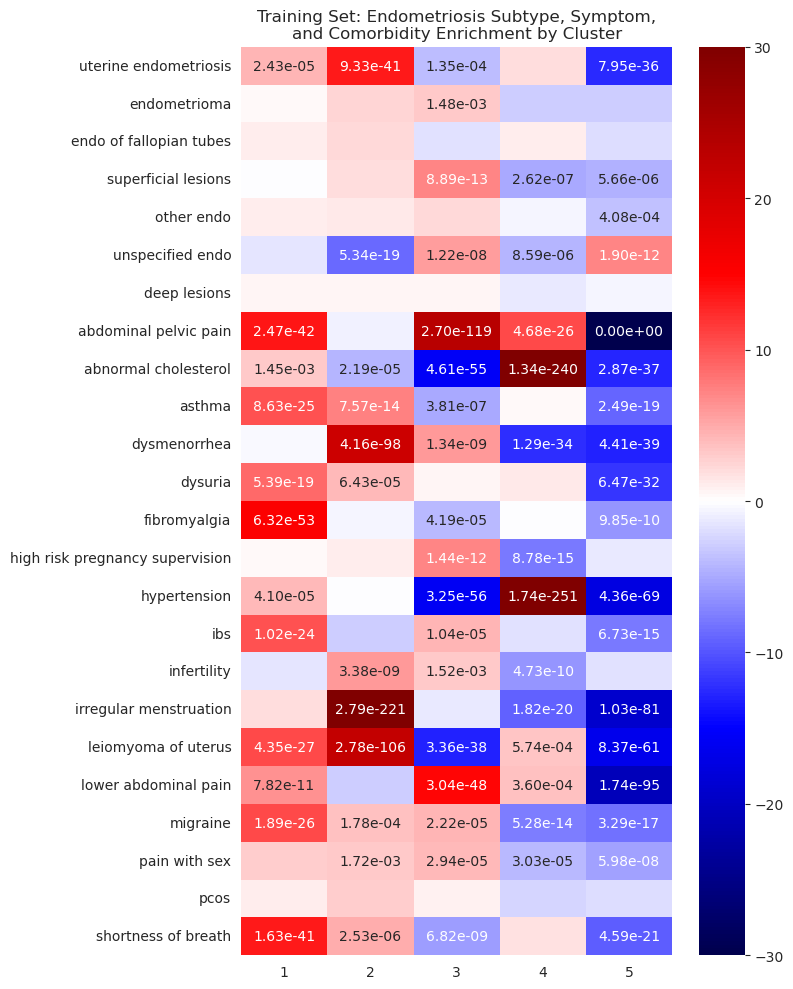

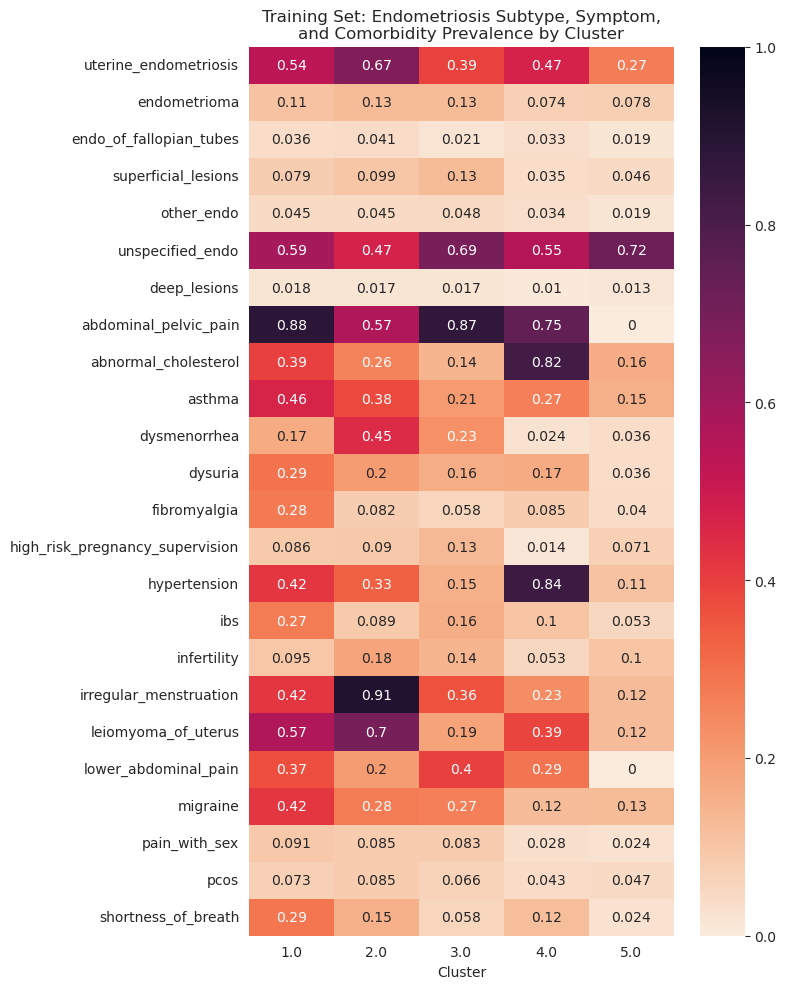

In [6]:
all_phenos = pd.read_csv('Pheno/FULL_PMBB_all_cleaned_phenos.csv', index_col='PMBB_ID')
all_phenos['endo_deep_lesions'] = (all_phenos['endo_N80.4'] | all_phenos['endo_N80.5']).fillna(0)

endo_cols = [c for c in all_phenos.columns if 'endo' in c]
endo_cols.remove('endometriosis')
endo_cols.remove('endo_N80.5')

endo_cols = [c for c in endo_cols if all_phenos.loc[clusters.index, c].mean() >= 0.01]
endo_cols = [c for c in endo_cols if all_phenos.loc[clusters.index, c].mean() < 1]

endo_cols.extend(list(model.feature_names_in_))

plot_phenos = all_phenos[endo_cols]

col_remap = {'endo_N80.1': 'endometrioma',
             'endo_deep_lesions': 'deep_lesions',
             'endo_N80.3': 'superficial_lesions',
             'endo_N80.2': 'endo_of_fallopian_tubes',
             'endo_N80.6': 'endo_in_cutaneous_scar',
             'endo_N80.8': 'other_endo',
             'endo_N80.9': 'unspecified_endo'}

plot_phenos = plot_phenos.rename(columns=col_remap)

fig, ax = plt.subplots()
fig.set_size_inches(8, 10)

cluster_ztests = pd.DataFrame()
cluster_ztests_P = pd.DataFrame()

for cluster in [1, 2, 3, 4, 5]:
    popA = clusters.index[clusters == cluster]
    popB = clusters.index[clusters != cluster]

    for trait in plot_phenos.columns:
        succA = plot_phenos.loc[popA, trait].sum()
        succB = plot_phenos.loc[popB, trait].sum()

        nObsA = plot_phenos.loc[popA, trait].count()
        nObsB = plot_phenos.loc[popB, trait].count()

        print(succA, succB, nObsA, nObsB)

        z, p = proportions_ztest(count=[succA, succB], nobs=[nObsA, nObsB], alternative='two-sided')

        cluster_ztests.loc[trait.replace('_', ' '), cluster] = z
        cluster_ztests_P.loc[trait.replace('_', ' '), cluster] = p

p_cutoff = 0.05 / len(endo_cols)
# p_cutoff = 0.005
# cluster_ztests_P = cluster_ztests_P[cluster_ztests_P.min(axis=1) < p_cutoff]
cluster_ztests_P = cluster_ztests_P.mask(cluster_ztests_P > p_cutoff).applymap(lambda x: '{:.2e}'.format(x)).replace('nan', '')
# cluster_ztests_P = cluster_ztests_P.map(lambda x: '{:.2e}'.format(x)).replace('nan', '')
cluster_ztests = cluster_ztests.loc[cluster_ztests_P.index]

sns.heatmap(cluster_ztests, annot=cluster_ztests_P, fmt='s', cmap='seismic',
            vmin=-30,
            vmax=30,
            ax=ax, yticklabels=True)

plt.title('Training Set: Endometriosis Subtype, Symptom,\nand Comorbidity Enrichment by Cluster')
plt.tight_layout()
plt.savefig('Plots/spectral_clustering_subtype_enrichment_training_set.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()

fig.set_size_inches(8, 10)

cluster_means = plot_phenos.fillna(0).groupby(clusters).mean().transpose()
sns.heatmap(cluster_means, annot=True, cmap=sns.cm.rocket_r, vmin=0, vmax=1)
plt.title('Training Set: Endometriosis Subtype, Symptom,\nand Comorbidity Prevalence by Cluster')
plt.tight_layout()
plt.savefig('Plots/training_set_feature_prevalence.png', bbox_inches='tight')
plt.show()

In [7]:
data = pd.read_csv('/project/verma_shared/projects/Endometriosis/Variables_After_Cleaning_031924_CMK_PMBBID.csv', index_col='PMBB_ID', low_memory=False)
data = data.loc[data.index.intersection(clusters_geno.index)]
data = data[data['ICD_1_with_N800'] == 1]
data

,PMBB_current,ANCESTRY,infertility_ICD,ICD_1_with_N800,ICD_1,CC1_ALL_with_N800,CC1_ALL,CC1_ALL_with_N800_with_US,CC1_ALL_with_US,CC1_RA_with_N800,...,diagnosis_type_endo,diagnosis_type_adeno,casesconfirmed,endoplusadenofibroids,endopluscomorbid,adenonotfibroids,adenoplusfibroids,endoonlynotfibroids,adenopluscomorbid,clinicalsubtype
PMBB_ID,,,,,,,,,,,,,,,,,,,,,
PMBB1026257511052,True,AFR,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,Surgery endo,Surgery adeno,1,1.0,NaN,NaN,NaN,NaN,NaN,2.0
PMBB1052559903931,True,EUR,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,Surgery endo,NaN,1,NaN,NaN,NaN,NaN,1.0,NaN,1.0
PMBB1058844982565,True,AFR,0.0,1.0,0.0,NaN,NaN,NaN,0.0,NaN,...,NaN,Surgery adeno,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN
PMBB1068915020777,True,AFR,0.0,1.0,0.0,NaN,NaN,NaN,0.0,NaN,...,NaN,Ultrasound adeno,1,NaN,NaN,1.0,NaN,NaN,NaN,NaN
PMBB1076069492162,True,AFR,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,Surgery endo,NaN,1,NaN,NaN,NaN,NaN,1.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PMBB9945691395858,True,AFR,0.0,1.0,0.0,NaN,NaN,1.0,0.0,NaN,...,NaN,Surgery adeno,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN
PMBB9946189022472,True,AFR,0.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,...,Ultrasound endo,NaN,1,1.0,1.0,NaN,NaN,NaN,NaN,3.0
PMBB9951428062088,True,AFR,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,Ultrasound endo,NaN,1,NaN,NaN,NaN,NaN,1.0,NaN,1.0


682
casesconfirmed    0.914956
conf_endo         0.480938
conf_adeno        0.564516
conf_fibroids     0.391496
dtype: float64
PROC_SURG_hormoneuse         float64
SURG_peritoneal              float64
SURG_ovarian                 float64
SURG_deep                    float64
symp_notincidental_pollie    float64
symp_pelvicpain_pollie       float64
symp_bleeding_pollie         float64
symp_dyspareunia_pollie      float64
symp_bowel_pollie            float64
symp_bladder_pollie          float64
symp_infertility_pollie      float64
symp_IBS_pollie              float64
symp_IBD_pollie              float64
symp_intcystitis_pollie      float64
symp_pcos_pollie             float64
symp_fibromyalgia_pollie     float64
conf_endo                      int64
conf_adeno                     int64
conf_fibroids                  int64
ICD_false_pos                  int64
dtype: object
1 ICD_false_pos 4 54 118 564
1 PROC_SURG_hormoneuse 12.0 94.0 71 341
1 SURG_deep 5.0 24.0 66 281
1 SURG_ovarian 11.0 62

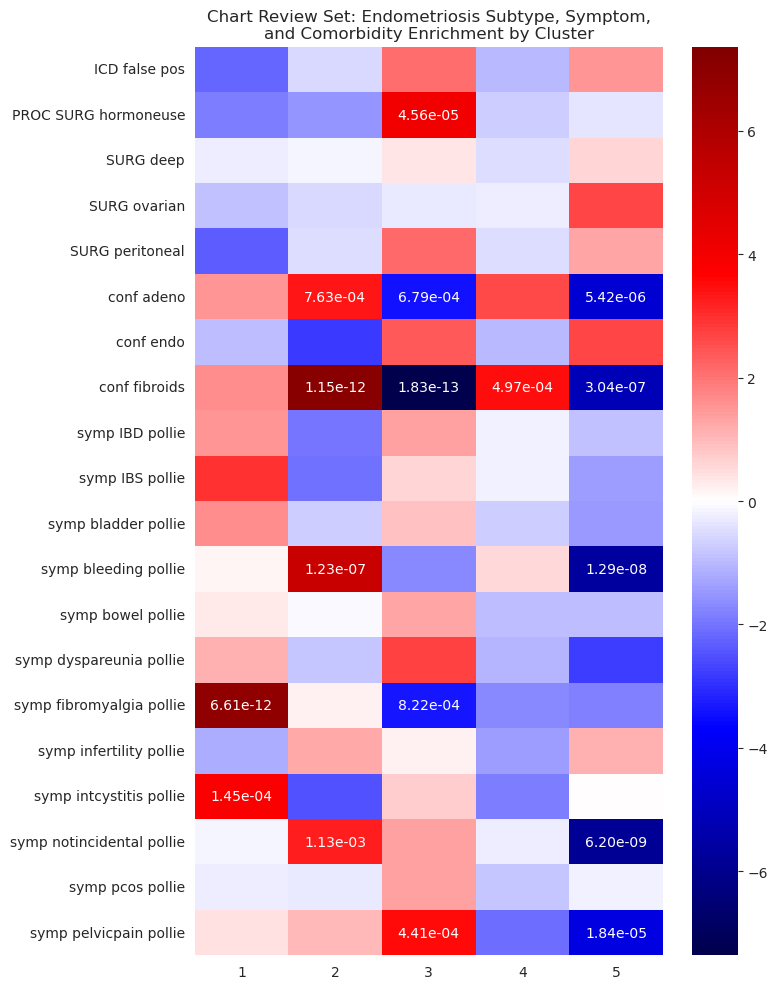

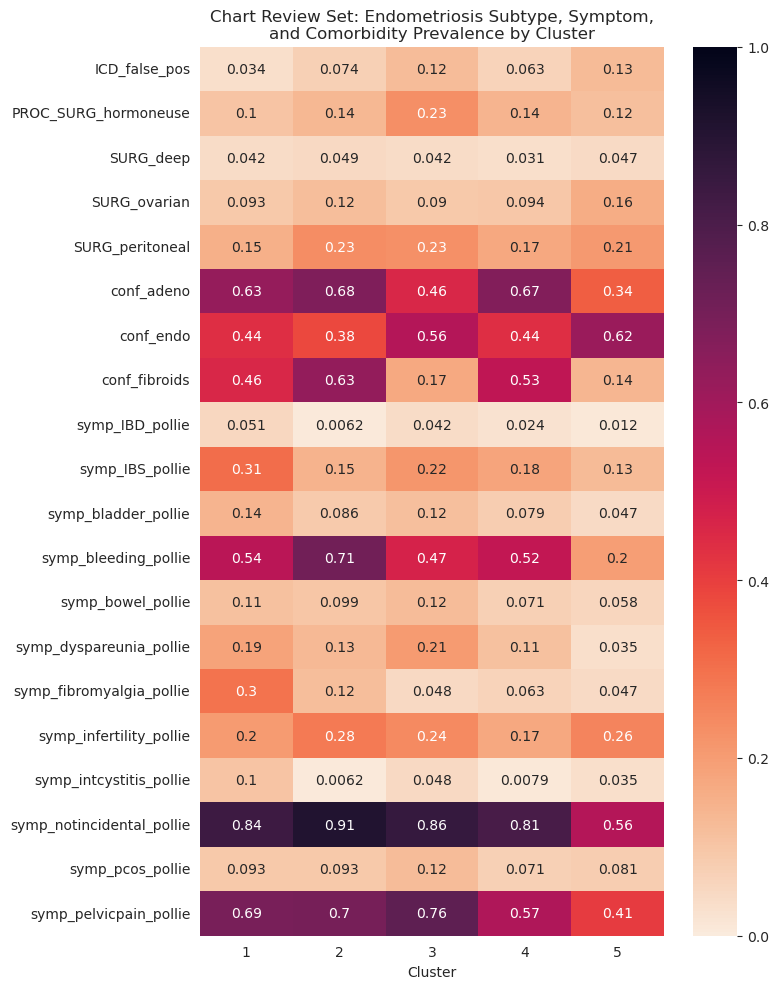

In [8]:
data = pd.read_csv('/project/verma_shared/projects/Endometriosis/Variables_After_Cleaning_031924_CMK_PMBBID.csv', index_col='PMBB_ID', low_memory=False)
data = data.loc[data.index.intersection(clusters_geno.index)]
data = data[data['ICD_1_with_N800'] == 1]
print(len(data))

true_controls = data.index[(data['controlschecked'] == 0) & (data['controlschecked'] == 0)]
endo_cases = data.index[data['endocase'] == 1]
adeno_cases = data.index[data['adenocase'] == 1]
fibroids_cases = data.index[data[['presumptive_fibroids', 'PROC_fibroids', 'SURG_fibroids']].fillna(0).max(axis=1) == 1]

all_phenos = pd.read_csv('../Feature_Extraction/Pheno/PMBB_2.3_pheno_covars.csv', index_col='PMBB_ID', low_memory=False)
all_phenos = all_phenos[all_phenos['endometriosis'] == 1]
all_phenos = all_phenos.loc[data.index.intersection(all_phenos.index)]
all_phenos = pd.concat([all_phenos, data], axis=1)

all_phenos['endo_deep_lesions'] = (all_phenos['endo_N80.4'] | all_phenos['endo_N80.5']).fillna(0)

all_phenos[['conf_endo', 'conf_adeno', 'conf_fibroids']] = 0
all_phenos.loc[endo_cases, 'conf_endo'] = 1
all_phenos.loc[adeno_cases, 'conf_adeno'] = 1
all_phenos.loc[true_controls, ['conf_endo', 'conf_adeno']] = 0
all_phenos.loc[fibroids_cases, 'conf_fibroids'] = 1
all_phenos['ICD_false_pos'] = (all_phenos[['conf_adeno', 'conf_endo']].max(axis=1) == 0).astype(int)

print(all_phenos[[c for c in all_phenos.columns if 'conf' in c]].mean())

# endo_cols = [c for c in all_phenos.columns if 'endo' in c and 'icd' not in c]
endo_cols = ['PROC_SURG_hormoneuse', 'SURG_peritoneal', 'SURG_ovarian', 'SURG_deep']
endo_cols.extend([c for c in data.columns if 'symp' in c and 'pollie' in c])
endo_cols.extend([c for c in all_phenos.columns if 'conf' in c])
endo_cols.append('ICD_false_pos')
endo_cols.remove('casesconfirmed')
# endo_cols.remove('endometriosis')
# endo_cols.remove('endo_N80.5')

clusters_chart = clusters_geno.loc[all_phenos.index.intersection(clusters_geno.index)]

print(all_phenos[endo_cols].dtypes)

endo_cols = [c for c in endo_cols if all_phenos.loc[clusters_chart.index, c].mean() >= 0.01]
endo_cols = [c for c in endo_cols if all_phenos.loc[clusters_chart.index, c].mean() < 1]

# endo_cols.extend(list(model.feature_names_in_))

col_remap = {'endo_N80.1': 'endometrioma',
             'endo_deep_lesions': 'deep_lesions',
             'endo_N80.3': 'superficial_lesions',
             'endo_N80.2': 'endo_of_fallopian_tubes',
             'endo_N80.6': 'endo_in_cutaneous_scar',
             'endo_N80.8': 'other_endo',
             'endo_N80.9': 'unspecified_endo',
             'PROC_SURG_hormoneuse': 'hormone_use_at_procedure'}

plot_phenos = plot_phenos.rename(columns=col_remap)
plot_phenos = all_phenos[sorted(list(set(endo_cols)))]

fig, ax = plt.subplots()
fig.set_size_inches(8, 10)

cluster_ztests = pd.DataFrame()
cluster_ztests_P = pd.DataFrame()

for cluster in [1, 2, 3, 4, 5]:
    popA = clusters_chart.index[clusters_chart == cluster]
    popB = clusters_chart.index[clusters_chart != cluster]

    for trait in plot_phenos.columns:
        succA = plot_phenos.loc[popA, trait].sum()
        succB = plot_phenos.loc[popB, trait].sum()

        nObsA = plot_phenos.loc[popA, trait].count()
        nObsB = plot_phenos.loc[popB, trait].count()

        print(cluster, trait, succA, succB, nObsA, nObsB)

        z, p = proportions_ztest(count=[succA, succB], nobs=[nObsA, nObsB], alternative='two-sided')

        cluster_ztests.loc[trait.replace('_', ' '), cluster] = z
        cluster_ztests_P.loc[trait.replace('_', ' '), cluster] = p

p_cutoff = 0.05 / len(endo_cols)
# p_cutoff = 0.005
# cluster_ztests_P = cluster_ztests_P[cluster_ztests_P.min(axis=1) < p_cutoff]
cluster_ztests_P = cluster_ztests_P.mask(cluster_ztests_P > p_cutoff).applymap(lambda x: '{:.2e}'.format(x)).replace('nan', '')
# cluster_ztests_P = cluster_ztests_P.map(lambda x: '{:.2e}'.format(x)).replace('nan', '')
cluster_ztests = cluster_ztests.loc[cluster_ztests_P.index]

sns.heatmap(cluster_ztests, annot=cluster_ztests_P, fmt='s', cmap='seismic',
            vmin=-cluster_ztests.abs().max().max(),
            vmax=cluster_ztests.abs().max().max(),
            ax=ax, yticklabels=True)

plt.title('Chart Review Set: Endometriosis Subtype, Symptom,\nand Comorbidity Enrichment by Cluster')
plt.tight_layout()
plt.savefig('Plots/spectral_clustering_subtype_enrichment_chart_review_set.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()

fig.set_size_inches(8, 10)

cluster_means = plot_phenos.fillna(0).groupby(clusters_geno).mean().transpose()
sns.heatmap(cluster_means, annot=True, cmap=sns.cm.rocket_r, vmin=0, vmax=1)
plt.title('Chart Review Set: Endometriosis Subtype, Symptom,\nand Comorbidity Prevalence by Cluster')
plt.tight_layout()
plt.savefig('Plots/chart_review_set_feature_prevalence.png', bbox_inches='tight')
plt.show()

1.0 dysuria 8.903922395654106 5.390714638434608e-19
1.0 migraine 10.642414626202115 1.8916261543494416e-26
1.0 ibs 10.263986161217517 1.023908110036488e-24
1.0 fibromyalgia 15.312389504285141 6.319876918026408e-53
1.0 asthma 10.280511552615696 8.62684924272021e-25
1.0 abdominal pelvic pain 13.635222274580507 2.472364042498936e-42
1.0 shortness of breath 13.49677669871159 1.6336874910480462e-41
2.0 dysmenorrhea 21.02157484737145 4.163864813713222e-98
2.0 infertility 5.912223288114763 3.3752056155279054e-09
2.0 irregular menstruation 31.754087411976034 2.788405037538218e-221
2.0 leiomyoma of uterus 21.896949223287226 2.777673465975699e-106
2.0 uterine endometriosis 13.367803268534779 9.3254428390643e-41
3.0 high risk pregnancy supervision 7.080390684101088 1.4374862081356394e-12
3.0 superficial lesions 7.146669175398177 8.890879972547151e-13
3.0 lower abdominal pain 14.59466091510313 3.037190311264806e-48
4.0 abnormal cholesterol 33.12408663483553 1.3376351213669398e-240
4.0 hypertension

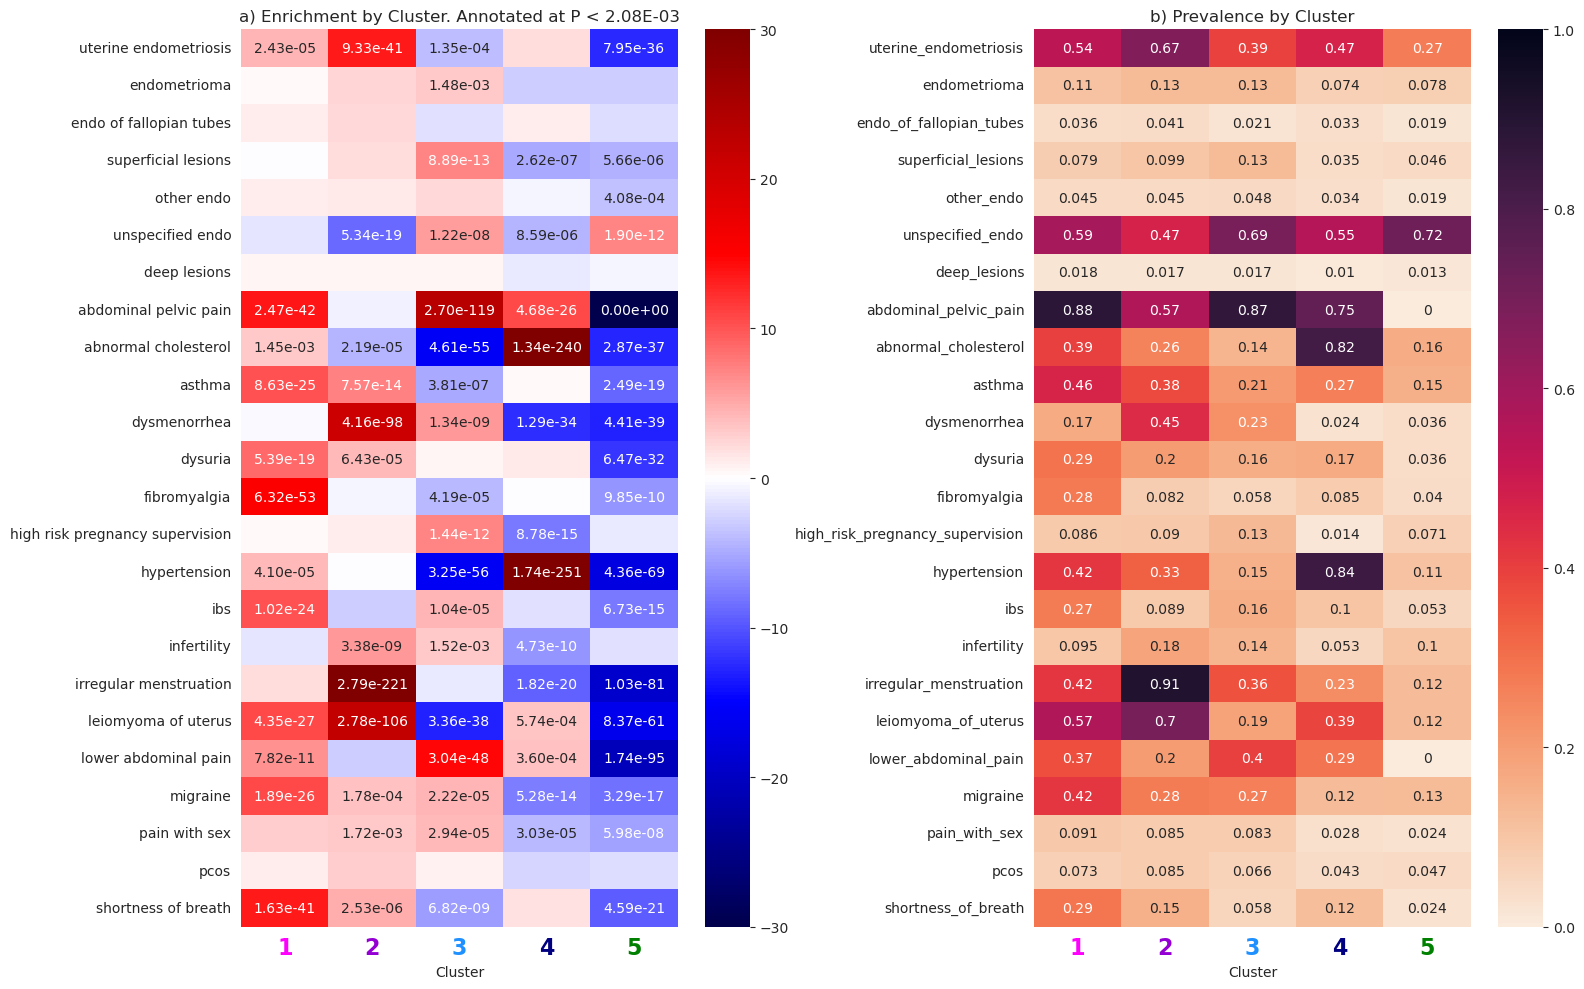

In [25]:
all_phenos = pd.read_csv('Pheno/FULL_PMBB_all_cleaned_phenos.csv', index_col='PMBB_ID')
all_phenos['endo_deep_lesions'] = (all_phenos['endo_N80.4'] | all_phenos['endo_N80.5']).fillna(0)

endo_cols = [c for c in all_phenos.columns if 'endo' in c]
endo_cols.remove('endometriosis')
endo_cols.remove('endo_N80.5')

endo_cols = [c for c in endo_cols if all_phenos.loc[clusters.index, c].mean() >= 0.01]
endo_cols = [c for c in endo_cols if all_phenos.loc[clusters.index, c].mean() < 1]

endo_cols.extend(list(model.feature_names_in_))

plot_phenos = all_phenos[endo_cols]

col_remap = {'endo_N80.1': 'endometrioma',
             'endo_deep_lesions': 'deep_lesions',
             'endo_N80.3': 'superficial_lesions',
             'endo_N80.2': 'endo_of_fallopian_tubes',
             'endo_N80.6': 'endo_in_cutaneous_scar',
             'endo_N80.8': 'other_endo',
             'endo_N80.9': 'unspecified_endo'}

plot_phenos = plot_phenos.rename(columns=col_remap)

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(16, 10)

cluster_ztests = pd.DataFrame()
cluster_ztests_P = pd.DataFrame()

for cluster in [1, 2, 3, 4, 5]:
    popA = clusters.index[clusters == cluster]
    popB = clusters.index[clusters != cluster]

    for trait in plot_phenos.columns:
        succA = plot_phenos.loc[popA, trait].sum()
        succB = plot_phenos.loc[popB, trait].sum()

        nObsA = plot_phenos.loc[popA, trait].count()
        nObsB = plot_phenos.loc[popB, trait].count()

        # print(succA, succB, nObsA, nObsB)

        z, p = proportions_ztest(count=[succA, succB], nobs=[nObsA, nObsB], alternative='two-sided')

        cluster_ztests.loc[trait.replace('_', ' '), cluster] = z
        cluster_ztests_P.loc[trait.replace('_', ' '), cluster] = p

p_cutoff = 0.05 / len(endo_cols)
# p_cutoff = 0.05 / np.product(cluster_ztests.shape)
# p_cutoff = 0.005
# cluster_ztests_P = cluster_ztests_P[cluster_ztests_P.min(axis=1) < p_cutoff]
cluster_means = plot_phenos.fillna(0).groupby(clusters).mean().transpose()
feature_winners = cluster_means.idxmax(axis=1).sort_values()
for feature, cluster in feature_winners.items():
    feature = feature.replace('_', ' ')
    if cluster_ztests_P.loc[feature, cluster] < p_cutoff:
        print(cluster, feature, cluster_ztests.loc[feature, cluster], cluster_ztests_P.loc[feature, cluster])

cluster_ztests_P = cluster_ztests_P.mask(cluster_ztests_P > p_cutoff).applymap(lambda x: '{:.2e}'.format(x)).replace('nan', '')
# cluster_ztests_P = cluster_ztests_P.map(lambda x: '{:.2e}'.format(x)).replace('nan', '')
cluster_ztests = cluster_ztests.loc[cluster_ztests_P.index]

ax = axes[0]

sns.heatmap(cluster_ztests, annot=cluster_ztests_P, fmt='s', cmap='seismic',
            vmin=-30,
            vmax=30,
            ax=ax, yticklabels=True)

ax.set_title(f'a) Enrichment by Cluster. Annotated at P < {p_cutoff:.2E}')
ax.set_xlabel('Cluster')

for tick in ax.get_xticklabels():
    tick_num = int(float(tick.get_text()))
    tick.set_text(str(tick_num))
    tick.set_color(f'C{tick_num-1}')
    tick.set_weight('bold')
    tick.set_size(16)

ax = axes[1]

cluster_means.columns = cluster_means.columns.astype(int)

sns.heatmap(cluster_means, annot=True, cmap=sns.cm.rocket_r, vmin=0, vmax=1, ax=ax)
ax.set_title('b) Prevalence by Cluster')

for tick in ax.get_xticklabels():
    tick_num = int(float(tick.get_text()))
    tick.set_color(f'C{tick_num-1}')
    tick.set_weight('bold')
    tick.set_size(16)

plt.tight_layout()
plt.savefig('../Manuscript_Plots/figure_3_training_set_feature_heatmaps.png', bbox_inches='tight')
plt.show()

682
casesconfirmed    0.914956
conf_endo         0.480938
conf_adeno        0.564516
conf_fibroids     0.391496
dtype: float64
PROC_SURG_hormoneuse         float64
SURG_peritoneal              float64
SURG_ovarian                 float64
SURG_deep                    float64
symp_notincidental_pollie    float64
symp_pelvicpain_pollie       float64
symp_bleeding_pollie         float64
symp_dyspareunia_pollie      float64
symp_bowel_pollie            float64
symp_bladder_pollie          float64
symp_infertility_pollie      float64
symp_IBS_pollie              float64
symp_IBD_pollie              float64
symp_intcystitis_pollie      float64
symp_pcos_pollie             float64
symp_fibromyalgia_pollie     float64
conf_endo                      int64
conf_adeno                     int64
conf_fibroids                  int64
ICD_false_pos                  int64
dtype: object
1 symp intcystitis pollie 3.799129931679779 0.0001452049560904283
1 symp fibromyalgia pollie 6.865796946592499 6.612106

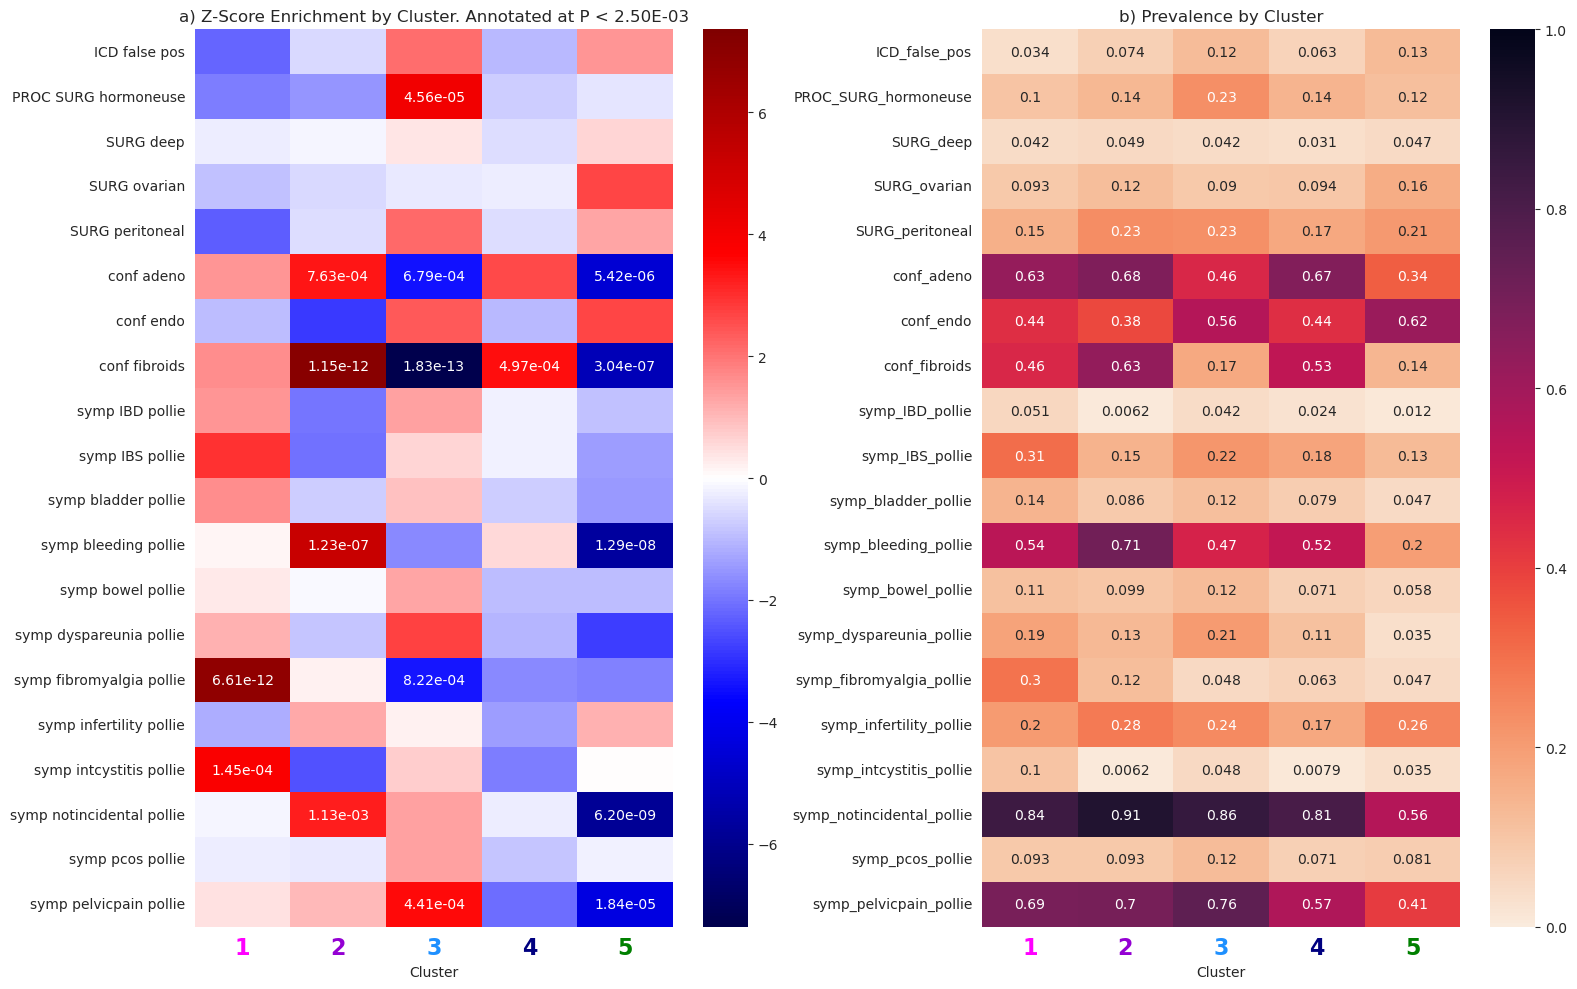

In [26]:
data = pd.read_csv('/project/verma_shared/projects/Endometriosis/Variables_After_Cleaning_031924_CMK_PMBBID.csv', index_col='PMBB_ID', low_memory=False)
data = data.loc[data.index.intersection(clusters_geno.index)]
data = data[data['ICD_1_with_N800'] == 1]
print(len(data))

true_controls = data.index[(data['controlschecked'] == 0) & (data['controlschecked'] == 0)]
endo_cases = data.index[data['endocase'] == 1]
adeno_cases = data.index[data['adenocase'] == 1]
fibroids_cases = data.index[data[['presumptive_fibroids', 'PROC_fibroids', 'SURG_fibroids']].fillna(0).max(axis=1) == 1]

all_phenos = pd.read_csv('../Feature_Extraction/Pheno/PMBB_2.3_pheno_covars.csv', index_col='PMBB_ID', low_memory=False)
all_phenos = all_phenos[all_phenos['endometriosis'] == 1]
all_phenos = all_phenos.loc[data.index.intersection(all_phenos.index)]
all_phenos = pd.concat([all_phenos, data], axis=1)

all_phenos['endo_deep_lesions'] = (all_phenos['endo_N80.4'] | all_phenos['endo_N80.5']).fillna(0)

all_phenos[['conf_endo', 'conf_adeno', 'conf_fibroids']] = 0
all_phenos.loc[endo_cases, 'conf_endo'] = 1
all_phenos.loc[adeno_cases, 'conf_adeno'] = 1
all_phenos.loc[true_controls, ['conf_endo', 'conf_adeno']] = 0
all_phenos.loc[fibroids_cases, 'conf_fibroids'] = 1
all_phenos['ICD_false_pos'] = (all_phenos[['conf_adeno', 'conf_endo']].max(axis=1) == 0).astype(int)

print(all_phenos[[c for c in all_phenos.columns if 'conf' in c]].mean())

# endo_cols = [c for c in all_phenos.columns if 'endo' in c and 'icd' not in c]
endo_cols = ['PROC_SURG_hormoneuse', 'SURG_peritoneal', 'SURG_ovarian', 'SURG_deep']
endo_cols.extend([c for c in data.columns if 'symp' in c and 'pollie' in c])
endo_cols.extend([c for c in all_phenos.columns if 'conf' in c])
endo_cols.append('ICD_false_pos')
endo_cols.remove('casesconfirmed')
# endo_cols.remove('endometriosis')
# endo_cols.remove('endo_N80.5')

clusters_chart = clusters_geno.loc[all_phenos.index.intersection(clusters_geno.index)]

print(all_phenos[endo_cols].dtypes)

endo_cols = [c for c in endo_cols if all_phenos.loc[clusters_chart.index, c].mean() >= 0.01]
endo_cols = [c for c in endo_cols if all_phenos.loc[clusters_chart.index, c].mean() < 1]

# endo_cols.extend(list(model.feature_names_in_))

col_remap = {'endo_N80.1': 'endometrioma',
             'endo_deep_lesions': 'deep_lesions',
             'endo_N80.3': 'superficial_lesions',
             'endo_N80.2': 'endo_of_fallopian_tubes',
             'endo_N80.6': 'endo_in_cutaneous_scar',
             'endo_N80.8': 'other_endo',
             'endo_N80.9': 'unspecified_endo',
             'PROC_SURG_hormoneuse': 'hormone_use_at_procedure'}

plot_phenos = plot_phenos.rename(columns=col_remap)
plot_phenos = all_phenos[sorted(list(set(endo_cols)))]

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(16, 10)

cluster_ztests = pd.DataFrame()
cluster_ztests_P = pd.DataFrame()

for cluster in [1, 2, 3, 4, 5]:
    popA = clusters_chart.index[clusters_chart == cluster]
    popB = clusters_chart.index[clusters_chart != cluster]

    for trait in plot_phenos.columns:
        succA = plot_phenos.loc[popA, trait].sum()
        succB = plot_phenos.loc[popB, trait].sum()

        nObsA = plot_phenos.loc[popA, trait].count()
        nObsB = plot_phenos.loc[popB, trait].count()

        # print(cluster, trait, succA, succB, nObsA, nObsB)

        z, p = proportions_ztest(count=[succA, succB], nobs=[nObsA, nObsB], alternative='two-sided')

        cluster_ztests.loc[trait.replace('_', ' '), cluster] = z
        cluster_ztests_P.loc[trait.replace('_', ' '), cluster] = p

p_cutoff = 0.05 / len(endo_cols)
# p_cutoff = 0.05 / np.product(cluster_ztests.shape)
# p_cutoff = 0.005
# cluster_ztests_P = cluster_ztests_P[cluster_ztests_P.min(axis=1) < p_cutoff]
cluster_means = plot_phenos.fillna(0).groupby(clusters_geno).mean().transpose()
feature_winners = cluster_means.idxmax(axis=1).sort_values()
for feature, cluster in feature_winners.items():
    feature = feature.replace('_', ' ')
    if cluster_ztests_P.loc[feature, cluster] < p_cutoff:
        print(cluster, feature, cluster_ztests.loc[feature, cluster], cluster_ztests_P.loc[feature, cluster])

cluster_ztests_P = cluster_ztests_P.mask(cluster_ztests_P > p_cutoff).applymap(lambda x: '{:.2e}'.format(x)).replace('nan', '')
# cluster_ztests_P = cluster_ztests_P.map(lambda x: '{:.2e}'.format(x)).replace('nan', '')
cluster_ztests = cluster_ztests.loc[cluster_ztests_P.index]

ax = axes[0]
sns.heatmap(cluster_ztests, annot=cluster_ztests_P, fmt='s', cmap='seismic',
            vmin=-cluster_ztests.abs().max().max(),
            vmax=cluster_ztests.abs().max().max(),
            ax=ax, yticklabels=True)

ax.set_title(f'a) Z-Score Enrichment by Cluster. Annotated at P < {p_cutoff:.2E}')
ax.set_xlabel('Cluster')

for tick in ax.get_xticklabels():
    tick_num = int(float(tick.get_text()))
    tick.set_color(f'C{tick_num-1}')
    tick.set_weight('bold')
    tick.set_size(16)

ax = axes[1]

cluster_means.columns = cluster_means.columns.astype(int)
sns.heatmap(cluster_means, annot=True, cmap=sns.cm.rocket_r, vmin=0, vmax=1, ax=ax)
ax.set_title('b) Prevalence by Cluster')

for tick in ax.get_xticklabels():
    tick_num = int(float(tick.get_text()))
    tick.set_color(f'C{tick_num-1}')
    tick.set_weight('bold')
    tick.set_size(16)

plt.tight_layout()
plt.savefig('../Manuscript_Plots/figure_4_chart_review_set_feature_heatmaps.png', bbox_inches='tight')
plt.show()